In [1]:
import os
import glob
import yaml
import csv
from dataclasses import dataclass
from pathlib import Path

import torch
import h5py
from transformers import BioGptTokenizer
from transformers import BioGptConfig
from histogpt.helpers.patching import main as patching_main, PatchingConfigs
from histogpt.models import HistoGPTForCausalLM, PerceiverResamplerConfig
from histogpt.helpers.inference import generate
from PIL import Image
import matplotlib.pyplot as plt
from openslide import OpenSlide


/usr/local/miniconda3/envs/mindpeak_dev/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Pre: Load Configs

In [2]:
config_path = os.path.join("..", "config", "wsi_data_pipe_config.yml")

with open(config_path, 'r') as file:
    config_data = yaml.safe_load(file)
print(config_data)

{'patching': {'slide_path': 'data/raw', 'save_path': 'data/interim/patches_and_embeds/', 'model_path': 'model_checkpoints/ctranspath/ctranspath.pth', 'file_extension': '.ndpi', 'patch_size': 256, 'batch_size': 24, 'preview_size': 4096, 'edge_threshold': 2, 'white_thresh': [170, 185, 175], 'black_thresh': [0, 0, 0], 'calc_thresh': [40, 40, 40], 'split': [0, 1], 'resolution_in_mpp': 0.0, 'downscaling_factor': 4.0, 'invalid_ratio_thresh': 0.3, 'exctraction_list': None, 'save_patch_images': True, 'save_tile_preview': False}, 'generation': {'model_path': 'model_checkpoints/histogpt/histogpt-1b-6k-pruned.pth', 'save_path': 'data/processed/clinical_reports/', 'tokenizer_path': 'model_checkpoints/biogpt', 'patching_model_name': 'ctranspath', 'length': 256, 'top_k': 40, 'top_p': 0.95, 'temp': 0.7}, 'aggregation': {'texts_path': 'data/processed/clinical_reports/', 'save_path': 'data/processed'}}


In [3]:
def update_paths_with_key_filter(config, root_path):
    updated_config = {}
    for key, value in config.items():
        if isinstance(value, dict):  # recursive dicts
            updated_config[key] = update_paths_with_key_filter(value, root_path)
        elif isinstance(value, str) and "path" in key.lower():  
            updated_config[key] = os.path.join(root_path, value)
        else:  # keep other values same
            updated_config[key] = value
    return updated_config

project_root = os.path.abspath(os.path.join("..")) 
updated_configs = update_paths_with_key_filter(config_data, project_root)
updated_configs

{'patching': {'slide_path': '/hy-tmp/wuxinghao/wsi_data_pipeline_dev/data/raw',
  'save_path': '/hy-tmp/wuxinghao/wsi_data_pipeline_dev/data/interim/patches_and_embeds/',
  'model_path': '/hy-tmp/wuxinghao/wsi_data_pipeline_dev/model_checkpoints/ctranspath/ctranspath.pth',
  'file_extension': '.ndpi',
  'patch_size': 256,
  'batch_size': 24,
  'preview_size': 4096,
  'edge_threshold': 2,
  'white_thresh': [170, 185, 175],
  'black_thresh': [0, 0, 0],
  'calc_thresh': [40, 40, 40],
  'split': [0, 1],
  'resolution_in_mpp': 0.0,
  'downscaling_factor': 4.0,
  'invalid_ratio_thresh': 0.3,
  'exctraction_list': None,
  'save_patch_images': True,
  'save_tile_preview': False},
 'generation': {'model_path': '/hy-tmp/wuxinghao/wsi_data_pipeline_dev/model_checkpoints/histogpt/histogpt-1b-6k-pruned.pth',
  'save_path': '/hy-tmp/wuxinghao/wsi_data_pipeline_dev/data/processed/clinical_reports/',
  'tokenizer_path': '/hy-tmp/wuxinghao/wsi_data_pipeline_dev/model_checkpoints/biogpt',
  'patching_mo

## 1. Generate embeddings of WSIs

In [4]:
try:
    pt_configs = updated_configs.get("patching")
    os.makedirs(pt_configs["save_path"], exist_ok=True)
    if not pt_configs:
        raise KeyError("The configuration file is missing the 'patching' section.")

    patch_configs = PatchingConfigs(**pt_configs)
    patching_main(patch_configs)
    print("WSI patches and embeddings generation completed successfully.")
except KeyError as e:
    print(f"Configuration error: {e}")
except Exception as e:
    print(f"An error occurred during patching and embedding generation: {e}")

/usr/local/miniconda3/envs/mindpeak_dev/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
                                                     

Time taken:  149.53919605351985 seconds
WSI patches and embeddings generation completed successfully.


## 2. Generate texts

In [5]:
@dataclass
class GenerationConfigs:
    model_path: str
    save_path: str
    tokenizer_path: str
    patching_model_name: str = "ctranspath"
    length: int = 256
    top_k: int = 20
    top_p: float = 0.7
    temp: float = 0.7

In [6]:
try:
    # Load configs
    patching_configs = PatchingConfigs(**updated_configs["patching"])
    generation_configs = GenerationConfigs(**updated_configs["generation"])

    # Load HistoGPT model
    histogpt = HistoGPTForCausalLM(BioGptConfig(), PerceiverResamplerConfig())
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    histogpt = histogpt.to(device)
    state_dict = torch.load(generation_configs.model_path, map_location=device)
    histogpt.load_state_dict(state_dict, strict=True)

    # Define feature directory
    wsi_feat_dir = (
        Path(patching_configs.save_path)
        / "h5_files"
        / f"{patching_configs.patch_size}px_{generation_configs.patching_model_name}_{patching_configs.resolution_in_mpp}mpp_{patching_configs.downscaling_factor}xdown_normal"
    )

    # Load tokenizer
    tokenizer = BioGptTokenizer.from_pretrained(generation_configs.tokenizer_path)
    prompt = "Final diagnosis:"
    prompt_tensor = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0).to(device)

    # Generate text for each WSI
    final_res = []
    os.makedirs(generation_configs.save_path, exist_ok=True)

    for file_path in glob.glob(os.path.join(wsi_feat_dir, "*.h5")):
        try:
            file_name = os.path.basename(file_path)
            prefix = file_name.split(".")[0]
            with h5py.File(file_path, "r") as wsi_h5_file:
                features = wsi_h5_file["feats"][:]
                features_tensor = torch.tensor(features).unsqueeze(0).to(device)
                output = generate(
                    model=histogpt,
                    prompt=prompt_tensor,
                    image=features_tensor,
                    length=generation_configs.length,
                    top_k=generation_configs.top_k,
                    top_p=generation_configs.top_p,
                    temp=generation_configs.temp,
                    device=device,
                    )
                text = tokenizer.decode(output[0, 1:])
                txt_file_path = os.path.join(
                    generation_configs.save_path, f"{prefix}.txt"
                )
                with open(txt_file_path, "w", encoding="utf-8") as txt_file:
                    txt_file.write(text)
                final_res.append([prefix, text])
                print(f"Finish generating clinical report for: {prefix}")
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")
    print("Clinical report generation completed successfully.")

except KeyError as e:
    print(f"Configuration error: Missing key {e}")
except FileNotFoundError as e:
    print(f"File not found: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Finish generating clinical report for: TCGA-GU-A42R-01A-01-TSA


Finish generating clinical report for: TCGA-GU-A763-01A-01-TS1


Finish generating clinical report for: TCGA-GU-AATQ-01A-01-TSA
Clinical report generation completed successfully.


### 3. Aggregation

In [7]:
try:
    aggregation_configs = updated_configs.get("aggregation")
    if not aggregation_configs:
        raise KeyError(
                "The configuration file is missing the 'aggregation' section."
        )

    save_path = aggregation_configs.get("save_path", "")
    texts_path = aggregation_configs.get("texts_path", "")
    if not save_path or not texts_path:
        raise ValueError(
                "Both 'save_path' and 'texts_path' must be specified in the configuration."
            )

    csv_file_path = os.path.join(save_path, "result.csv")
    final_res = []


    for report_file in Path(texts_path).glob("*.txt"):
        try:
            with open(report_file, "r", encoding="utf-8") as file:
                final_res.append([report_file.stem, file.read()])
        except Exception as e:
            print(f"Error reading file {report_file}: {e}")

    if not final_res:
        print(
                "No text files were processed. Ensure the directory contains '.txt' files."
        )

    with open(csv_file_path, mode="w", newline="", encoding="utf-8") as csv_file:
        csv_writer = csv.writer(csv_file)
        csv_writer.writerow(["WSI Name", "Generated Text"])
        csv_writer.writerows(final_res)

    print(f"Final result.csv stored in: {csv_file_path}")

except Exception as e:
    print(f"An error occurred during aggregation: {e}")

Final result.csv stored in: /hy-tmp/wuxinghao/wsi_data_pipeline_dev/data/processed/result.csv


## Result Sample


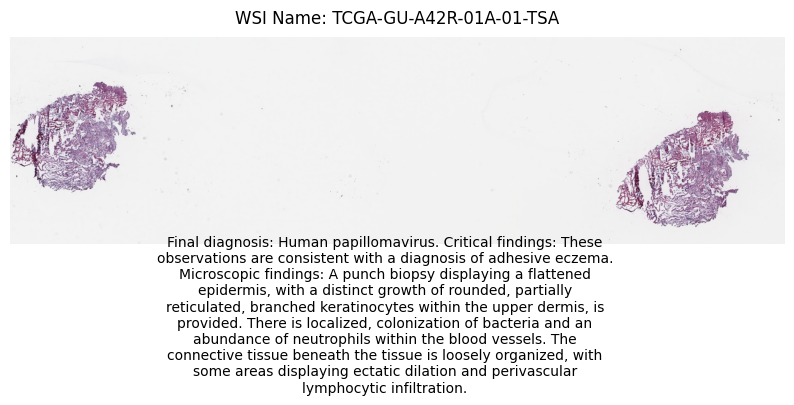

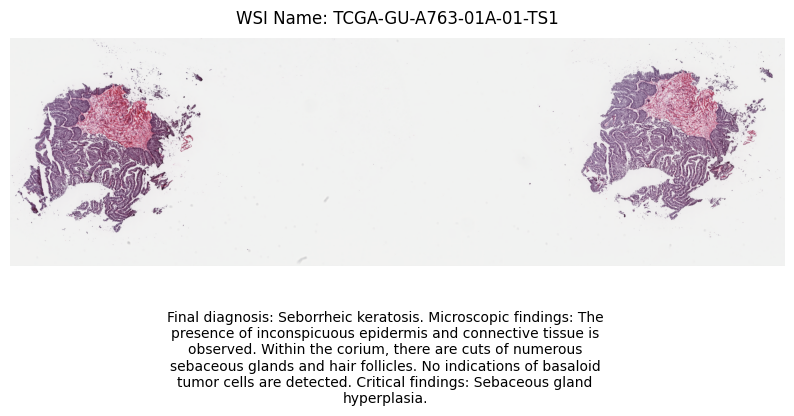

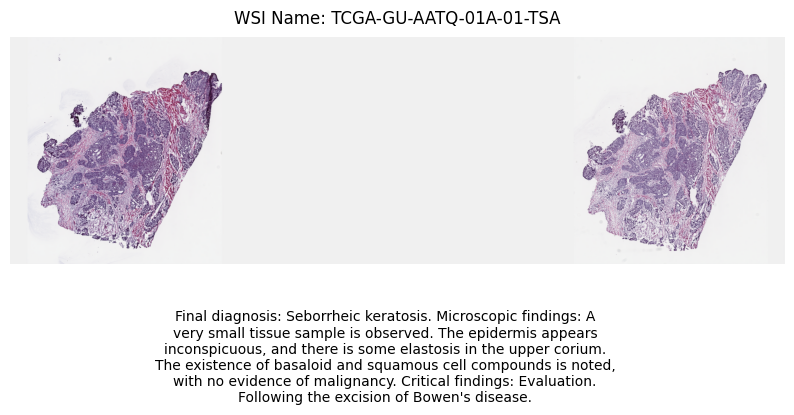

In [8]:
import pandas as pd
import textwrap
results = pd.read_csv(csv_file_path)

for _, row in results.iterrows():
    wsi_name = row["WSI Name"]
    generated_text = row["Generated Text"]
    
    matched_image = None
    for image_file in os.listdir(patching_configs.slide_path):
        if wsi_name in image_file:
            matched_image = os.path.join(patching_configs.slide_path, image_file)
            break
    
    if matched_image:
        try:
            slide = OpenSlide(matched_image)
            
            # Get the best level for a 32x downsample
            level = slide.get_best_level_for_downsample(32)
            downsampled_dimensions = slide.level_dimensions[level]
            
            # Read and process the slide thumbnail
            thumbnail = slide.read_region((0, 0), level, downsampled_dimensions)
            thumbnail = thumbnail.convert("RGB")
            
            # Plot the image
            plt.figure(figsize=(10, 6))
            plt.imshow(thumbnail)
            plt.axis("off")
            
            # Prepare title with WSI Name and Generated Text
            wrapped_text = textwrap.fill(generated_text, width=64)
            title = f"WSI Name: {wsi_name}"
            subtitle = f"{wrapped_text}"
            
            # Adjust layout to reduce spacing
            plt.title(title, fontsize=12, pad=10, loc='center')  
            plt.figtext(0.5, 0.1, subtitle, wrap=True, ha='center', fontsize=10)  
            plt.subplots_adjust(bottom=0.15)  
            plt.show()
        except Exception as e:
            print(f"Cannot handle the file {matched_image}: {e}")
    else:
        print(f"Cannot find the WSI file for {wsi_name}.")